### Imports

In [76]:
# Imports

# standard stuff
import pandas as pd
import numpy as np
from collections import Counter
import os
# Binn stuff
from binn import Network
from binn import BINN
from binn import BINNExplainer
# from the github of the binn
from util_for_examples import fit_data_matrix_to_network_input, generate_data
# our custom functions for training and testing
from cust_functions import training as trg
# torch stuff
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# Sklearn stuff
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
SEED = 42
trg.set_seed(SEED)

### Get Data

In [77]:
# Import covid data
covid_train = pd.read_csv('covid_data/covid_train_qm.csv', index_col=0)
covid_test = pd.read_csv('covid_data/covid_test_qm.csv', index_col=0)

covid_train_design = pd.read_csv('covid_data/covid_train_design_qm.csv', index_col=0)
covid_test_design = pd.read_csv('covid_data/covid_test_design_qm.csv', index_col=0)
covid_train_design["group"]+=1
covid_test_design["group"]+=1
translation = pd.read_csv("aki_data/translation.tsv", sep="\t", index_col=0)
pathways = pd.read_csv("aki_data/pathways.tsv", sep="\t")

In [78]:
#### Import aki data

# Get data, we have to tranform it first
input_data = pd.read_csv("aki_data/test_data.tsv", sep="\t", )
input_data_qm = pd.read_csv("aki_data/test_qm.csv")
translation = pd.read_csv("aki_data/translation.tsv", sep="\t", index_col=0)
pathways = pd.read_csv("aki_data/pathways.tsv", sep="\t")
design_matrix = pd.read_csv("aki_data/design_matrix.tsv", sep="\t")

# split into test and train according to paper
tm_p19_cols = [col for col in input_data_qm.columns if col.startswith("TM_P19")]
tm_m2012_cols = [col for col in input_data_qm.columns if col.startswith("TM_M2012")]

# Create train/test input based on these columns
test_input_data = input_data_qm[tm_p19_cols]
train_input_data = input_data_qm[tm_m2012_cols]
first_column = input_data_qm.iloc[:, 0]
train_input_data.insert(0, first_column.name, first_column)
test_input_data.insert(0, first_column.name, first_column)

#design_matrix
tm_m2012 = design_matrix['sample'].str.startswith("TM_M2012")
tm_p19 = design_matrix['sample'].str.startswith("TM_P19")
# Use the mask to create the separate DataFrames
test_design_matrix = design_matrix[tm_p19]
train_design_matrix = design_matrix[tm_m2012]

### AKI
- We perform 5-fold-CV

In [79]:
# 5 fold CV

# We first create an X tensor and a y tensor for the Corss validation. For this we create network/binn and make our x,y data so it fits the required input format
############# start of data creation ################
network = Network(
    input_data    =   train_input_data, 
    pathways      =   pathways,
    mapping       =   translation,
    input_data_column = "Protein", 
    source_column = "child", 
    target_column = "parent",
    subset_pathways = True
    )
binn = BINN(
        network=network,
        n_layers=4,
        dropout=0.2,
        validate=False,
        residual=False,
        device="cpu",
        learning_rate=0.001
    )

# Given functions to make the data network compatible
protein_matrix = fit_data_matrix_to_network_input(train_input_data, features=network.inputs)
X, y = generate_data(protein_matrix, design_matrix=train_design_matrix)
# Change to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.int16)

################ end of data creation ################

# Place where we store the data
model_save_dir = "trained_models/AKI_BINN"
os.makedirs(model_save_dir, exist_ok=True)

# cross validation 5-times
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# we dont need more epochs 30 sufficient
num_epochs = 30
fold = 0
results = {}

for train_index, val_index in kf.split(X_tensor):
    fold += 1
    print(f"Starting fold {fold}")
    
    # Initialize a new network each fold
    network = Network(
    input_data    =   input_data_qm, # use the preprocessed data
    pathways      =   pathways,
    mapping       =   translation,
    input_data_column = "Protein", # This is the default value
    source_column = "child", # defined by our pathways-file
    target_column = "parent",
    subset_pathways = True # This is the default value
    )
    # Initate binn_aki for AKI
    binn_aki = BINN(
        network=network,
        n_layers=4,
        dropout=0.2,
        validate=False,
        residual=False,
        device="cpu",
        learning_rate=0.001
    )

    # train/ validation split
    X_train, X_val = X_tensor[train_index], X_tensor[val_index]
    y_train, y_val = y_tensor[train_index], y_tensor[val_index]
    # tensors
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val) 
    # Load the data according to binn documentation
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, drop_last=True)
    # get the opitmizer according to binn documentation
    optimizer = binn_aki.configure_optimizers()[0][0]
    
    # results dict
    results[fold] = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], "train_f1_macro":  [], "val_f1_macro":  [], "train_roc_auc": [], "val_roc_auc": [],
                     'train_f1_phen1': [], 'train_f1_phen2': [], 'train_recall_phen1': [], 'train_recall_phen2': [], 'train_precision_phen1': [], 'train_precision_phen2': [],
                     'val_f1_phen1': [], 'val_f1_phen2': [], 'val_recall_phen1': [], 'val_recall_phen2': [], 'val_precision_phen1': [], 'val_precision_phen2': [],"val_cm":[]
                     }
    # for best epoch needed later for plotting results
    best_val_loss = np.inf
    best_epoch = -1
    best_model_state = None
    # train the binn
    for epoch in range(num_epochs):
        # Training
        binn_aki.train()
        total_loss = 0.0
        total_accuracy = 0

        train_true_labels = []
        train_predictions = []

        val_true_labels = []  
        val_predictions = []

        for inputs, targets in train_loader:
            inputs = inputs.to(binn_aki.device)
            targets = targets.to(binn_aki.device).type(torch.LongTensor)
            optimizer.zero_grad()
            outputs = binn_aki(inputs)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_accuracy += torch.sum(torch.argmax(outputs, axis=1) == targets) / len(targets)
            train_true_labels.append(targets.cpu().numpy())
            train_predictions.append(outputs.cpu().detach().numpy())  
        # get things for roc and cm
        train_true_labels = np.concatenate(train_true_labels)
        train_logits = np.concatenate(train_predictions, axis=0)
        train_probs = torch.softmax(torch.tensor(train_logits), dim=1).numpy()  # Assuming binary classification
        train_roc_auc = roc_auc_score(train_true_labels, train_probs[:, 1])
        train_pred_labels = np.argmax(train_probs, axis=1)
        
        # Get the metrics#########
        train_cm = confusion_matrix(train_true_labels, train_pred_labels)
        train_metrics = trg.calculate_metrics(train_cm)
        recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = train_metrics
        # loss and accuracy
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_accuracy / len(train_loader)

        # add results
        results[fold]['train_loss'].append(avg_loss)
        results[fold]['train_accuracy'].append(accuracy.item())  # Ensure it's a scalar
        results[fold]['train_f1_macro'].append(f1_macro)
        results[fold]['train_roc_auc'].append(train_roc_auc)
        results[fold]['train_f1_phen1'].append(f1_phen1)
        results[fold]['train_f1_phen2'].append(f1_phen2)
        results[fold]['train_recall_phen1'].append(recall_phen1)
        results[fold]['train_recall_phen2'].append(recall_phen2)
        results[fold]['train_precision_phen1'].append(precision_phen1)
        results[fold]['train_precision_phen2'].append(precision_phen2)
        # Prints
        print(f'Epoch {epoch}, Training Average Accuracy {avg_accuracy}, Average Loss: {avg_loss}')

        #### start of  Validation ####
        binn_aki.eval()
        val_loss = 0.0
        val_accuracy = 0
        # evaluate
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(binn_aki.device)
                targets = targets.to(binn_aki.device).type(torch.LongTensor)
                outputs = binn_aki(inputs)
                loss = F.cross_entropy(outputs, targets)
                val_loss += loss.item()
                val_accuracy += torch.sum(torch.argmax(outputs, axis=1) == targets) / len(targets)
                val_true_labels.append(targets.cpu().numpy())
                val_predictions.append(outputs.cpu().detach().numpy())  
        # roc and cm stuff and other metric stuff
        val_true_labels = np.concatenate(val_true_labels)
        val_logits = np.concatenate(val_predictions, axis=0)
        val_probs = torch.softmax(torch.tensor(val_logits), dim=1).numpy()  # Assuming binary classification
        val_roc_auc = roc_auc_score(val_true_labels, val_probs[:, 1])
        val_pred_labels = np.argmax(val_probs, axis=1)
        val_cm = confusion_matrix(val_true_labels, val_pred_labels)
        val_metrics = trg.calculate_metrics(val_cm) 
        recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macr = val_metrics       
        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        # prints
        print(f'Epoch {epoch}, Validation Average Accuracy {avg_val_accuracy}, Average Loss: {avg_val_loss}')
        
        # get results
        results[fold]['val_loss'].append(avg_val_loss)
        results[fold]['val_accuracy'].append(accuracy.item())  # Ensure it's a scalar
        results[fold]['val_f1_macro'].append(f1_macr)
        results[fold]['val_roc_auc'].append(val_roc_auc)
        results[fold]['val_f1_phen1'].append(f1_phen1)
        results[fold]['val_f1_phen2'].append(f1_phen2)
        results[fold]['val_recall_phen1'].append(recall_phen1)
        results[fold]['val_recall_phen2'].append(recall_phen2)
        results[fold]['val_precision_phen1'].append(precision_phen1)
        results[fold]['val_precision_phen2'].append(precision_phen2)
        results[fold]['val_cm'].append(val_cm)
        # best model stuff
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            best_model_state = binn_aki.state_dict().copy()

    if best_model_state is not None:
        model_save_path = os.path.join(model_save_dir, f"best_model_fold_{fold}.pth")
        torch.save(best_model_state, model_save_path)
    results[fold]['best_val_epoch'] = best_epoch
    # Safe the 5 models in the folder
    model_save_path = os.path.join(model_save_dir, f"model_fold_{fold}.pth")
    torch.save(binn_aki.state_dict(), model_save_path)

    print(f"Model saved for fold {fold} at {model_save_path}")


BINN is on the device: cpu
dasdf
Starting fold 1

BINN is on the device: cpu
Epoch 0, Training Average Accuracy 0.5803571343421936, Average Loss: 0.7278988701956612
Epoch 0, Validation Average Accuracy 0.4166666567325592, Average Loss: 0.6960683465003967
Epoch 1, Training Average Accuracy 0.6964285969734192, Average Loss: 0.5690006986260414
Epoch 1, Validation Average Accuracy 0.5416666865348816, Average Loss: 0.6890131632486979
Epoch 2, Training Average Accuracy 0.7857142686843872, Average Loss: 0.5462133118084499
Epoch 2, Validation Average Accuracy 0.9166666865348816, Average Loss: 0.6278461416562399
Epoch 3, Training Average Accuracy 0.8214285969734192, Average Loss: 0.4193757155111858
Epoch 3, Validation Average Accuracy 0.9166666865348816, Average Loss: 0.44102996587753296
Epoch 4, Training Average Accuracy 0.7767857313156128, Average Loss: 0.4031062200665474
Epoch 4, Validation Average Accuracy 0.8333333134651184, Average Loss: 0.32784117261568707
Epoch 5, Training Average Accu

### Print metrics and scors

Average validation accuracy: 0.975 +/- 0.02
Average validation roc_auc: 0.999 +/- 0.0
Average validation f1_macro: 0.974 +/- 0.02
Average validation f1_phen1: 0.975 +/- 0.02
Average validation f1_phen2: 0.974 +/- 0.02
Average validation recall_phen1: 0.986 +/- 0.03
Average validation recall_phen2: 0.968 +/- 0.04
Average validation precision_phen1: 0.966 +/- 0.04
Average validation precision_phen2: 0.982 +/- 0.04


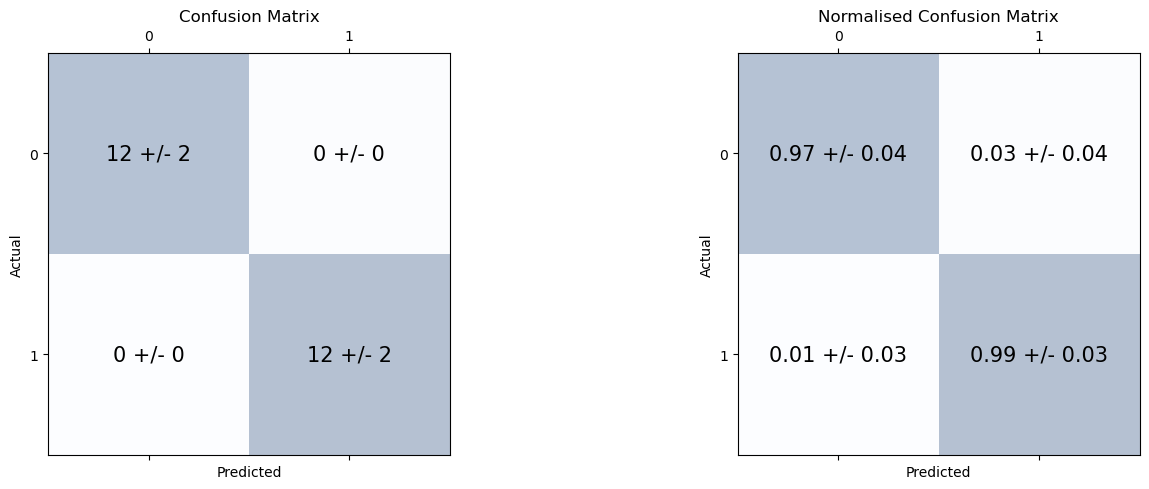

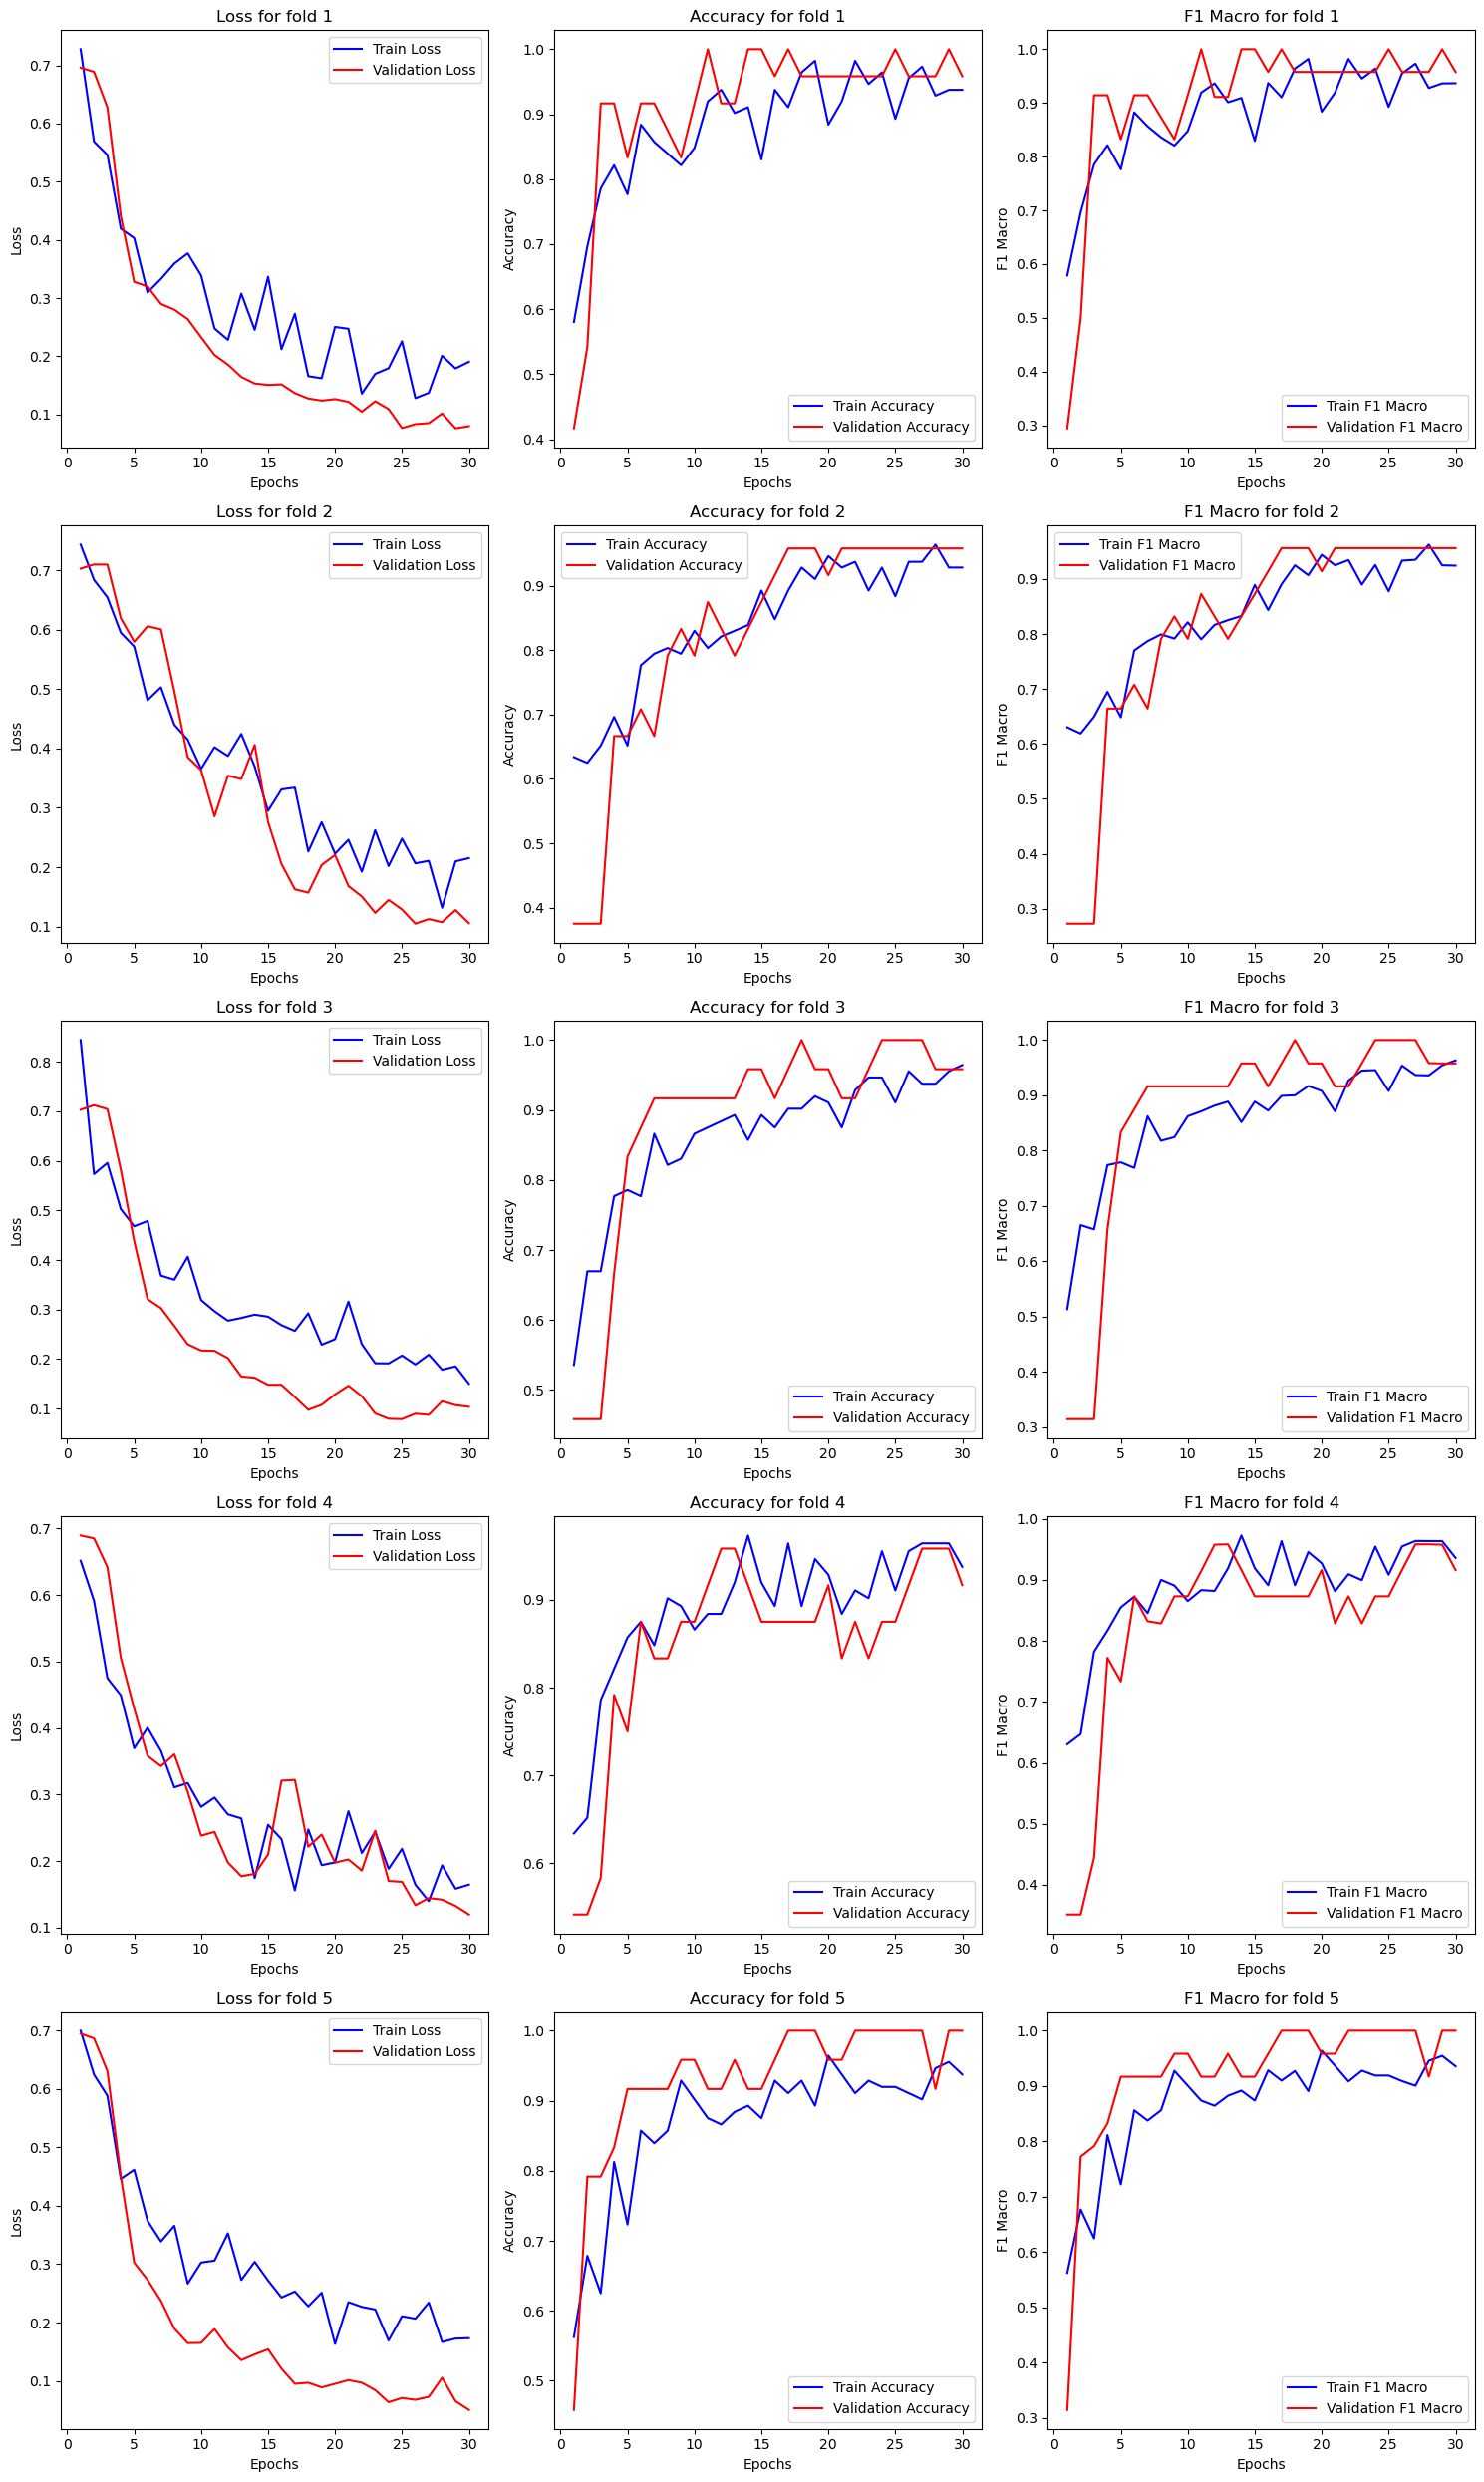

In [80]:
trg.print_val_results(results)
trg.plot_confusion_matrix(results)
trg.plot_results(results, 5)

### Testing of the AKI data

dasdf
Test Accuracy: 0.8571
Test ROC_AUC: 0.9000
Test F1 Macro: 0.8444
Test F1 Phen1: 0.8889
Test F1 Phen2: 0.8000
Test Recall Phen1: 0.8000
Test Recall Phen2: 1.0000


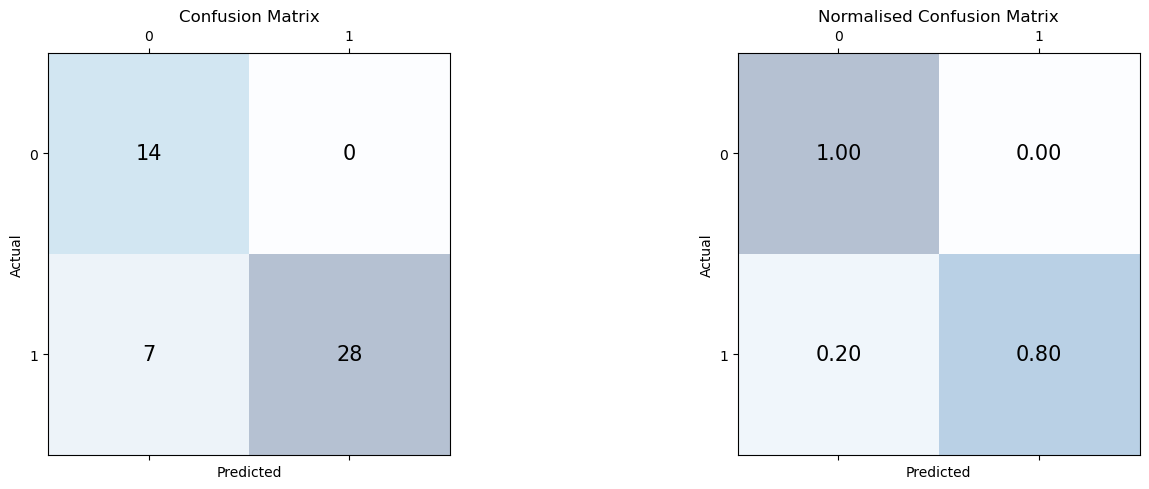

In [82]:
# Test

num_folds = 5  
model_save_dir = "trained_models/AKI_BINN"  

# Load test data analogue to the train part
protein_matrix_test = fit_data_matrix_to_network_input(test_input_data, features=network.inputs)
X_test, y_test = generate_data(protein_matrix_test, design_matrix=test_design_matrix)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)  # tryout long instead of int16
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8)  # Adjust batch size as needed

# get the predictions
all_predictions = []

# We go through each of the 5 cv models and get the predictions
for fold in range(1, num_folds + 1):
    model_path = f"{model_save_dir}/model_fold_{fold}.pth"
    model = binn_aki 
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(binn_aki.device)

    fold_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(binn_aki.device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            fold_predictions.extend(predicted.cpu().numpy())

    all_predictions.append(fold_predictions)


all_predictions = list(map(list, zip(*all_predictions)))
# majority voting
majority_votes = [Counter(sample_predictions).most_common(1)[0][0] for sample_predictions in all_predictions]

# accuracy
y_test = y_test_tensor.numpy()  # Convert to numpy if it's a tensor
correct = sum(1 for true, pred in zip(y_test, majority_votes) if true == pred)
accuracy = 100 * correct / len(y_test)

# cm, roc and other metrics
test_confusion_matrix = confusion_matrix(y_test, majority_votes, labels=[0, 1])

test_roc_auc = roc_auc_score(y_test, majority_votes)

recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = trg.calculate_metrics(test_confusion_matrix)



# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC_AUC: {test_roc_auc:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")
print(f"Test F1 Phen1: {f1_phen1:.4f}")
print(f"Test F1 Phen2: {f1_phen2:.4f}")
print(f"Test Recall Phen1: {recall_phen1:.4f}")
print(f"Test Recall Phen2: {recall_phen2:.4f}")
trg.plot_confusion_matrix(test_confusion_matrix, use = 'test')

### Covid
- we train 5-fold-cv
- The code is the same as for the AKI only the data is different!!!!

In [83]:
### Training with k=5 CV
# Initiate network

# Same as in the AKI just different data
network = Network(
    input_data    =   covid_train, 
    pathways      =   pathways,
    mapping       =   translation,
    input_data_column = "Protein", 
    source_column = "child", 
    target_column = "parent",
    subset_pathways = True 
    )
binn = BINN(
    network=network,
    n_layers=4,
    dropout=0.2,
    validate=False,
    residual=False,
    device="cpu",
    learning_rate=0.001
)

protein_matrix = fit_data_matrix_to_network_input(covid_train, features=network.inputs)
X, y = generate_data(protein_matrix, design_matrix=covid_train_design)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.int16)

model_save_dir = "trained_models/Covid_BINN"
os.makedirs(model_save_dir, exist_ok=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

num_epochs = 30
fold = 0
results = {}

for train_index, val_index in kf.split(X_tensor):
    fold += 1
    print(f"Starting fold {fold}")
    
    network = Network(
    input_data    =   covid_train, 
    pathways      =   pathways,
    mapping       =   translation,
    input_data_column = "Protein",
    source_column = "child", 
    target_column = "parent",
    subset_pathways = True 
    )
    binn_covid = BINN(
        network=network,
        n_layers=4,
        dropout=0.2,
        validate=False,
        residual=False,
        device="cpu",
        learning_rate=0.001
    )

    X_train, X_val = X_tensor[train_index], X_tensor[val_index]
    y_train, y_val = y_tensor[train_index], y_tensor[val_index]

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, drop_last=True)

    optimizer = binn_covid.configure_optimizers()[0][0]
    
    # results dict
    results[fold] = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [], "train_f1_macro":  [], "val_f1_macro":  [], "train_roc_auc": [], "val_roc_auc": [],
                     'train_f1_phen1': [], 'train_f1_phen2': [], 'train_recall_phen1': [], 'train_recall_phen2': [], 'train_precision_phen1': [], 'train_precision_phen2': [],
                     'val_f1_phen1': [], 'val_f1_phen2': [], 'val_recall_phen1': [], 'val_recall_phen2': [], 'val_precision_phen1': [], 'val_precision_phen2': [],"val_cm":[]
                     }
    # for best epoch needed later for plotting results
    best_val_loss = np.inf
    best_epoch = -1
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        binn_covid.train()
        total_loss = 0.0
        total_accuracy = 0

        train_true_labels = []
        train_predictions = []

        val_true_labels = []
        val_predictions = []

        for inputs, targets in train_loader:
            inputs = inputs.to(binn_covid.device)
            targets = targets.to(binn_covid.device).type(torch.LongTensor)
            optimizer.zero_grad()
            outputs = binn_covid(inputs)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_accuracy += torch.sum(torch.argmax(outputs, axis=1) == targets) / len(targets)

            train_true_labels.append(targets.cpu().numpy())
            train_predictions.append(outputs.cpu().detach().numpy())  

        train_true_labels = np.concatenate(train_true_labels)
        train_logits = np.concatenate(train_predictions, axis=0)
        train_probs = torch.softmax(torch.tensor(train_logits), dim=1).numpy()  # Assuming binary classification
        train_roc_auc = roc_auc_score(train_true_labels, train_probs[:, 1])
        
        train_pred_labels = np.argmax(train_probs, axis=1)
        

        # Get the metrics
        train_cm = confusion_matrix(train_true_labels, train_pred_labels)
        train_metrics = trg.calculate_metrics(train_cm)
        recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = train_metrics
        # loss and accuracy
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_accuracy / len(train_loader)

        # add results
        results[fold]['train_loss'].append(avg_loss)
        results[fold]['train_accuracy'].append(accuracy.item())  # Ensure it's a scalar
        results[fold]['train_f1_macro'].append(f1_macro)
        results[fold]['train_roc_auc'].append(train_roc_auc)
        results[fold]['train_f1_phen1'].append(f1_phen1)
        results[fold]['train_f1_phen2'].append(f1_phen2)
        results[fold]['train_recall_phen1'].append(recall_phen1)
        results[fold]['train_recall_phen2'].append(recall_phen2)
        results[fold]['train_precision_phen1'].append(precision_phen1)
        results[fold]['train_precision_phen2'].append(precision_phen2)
        #############
        
        print(f'Epoch {epoch}, Training Average Accuracy {avg_accuracy}, Average Loss: {avg_loss}')

        # Validation
        binn_covid.eval()
        val_loss = 0.0
        val_accuracy = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(binn_covid.device)
                targets = targets.to(binn_covid.device).type(torch.LongTensor)
                outputs = binn_covid(inputs)
                loss = F.cross_entropy(outputs, targets)
                val_loss += loss.item()
                val_accuracy += torch.sum(torch.argmax(outputs, axis=1) == targets) / len(targets)

                val_true_labels.append(targets.cpu().numpy())
                val_predictions.append(outputs.cpu().detach().numpy())  

        val_true_labels = np.concatenate(val_true_labels)
        val_logits = np.concatenate(val_predictions, axis=0)
        val_probs = torch.softmax(torch.tensor(val_logits), dim=1).numpy()  # Assuming binary classification
        val_roc_auc = roc_auc_score(val_true_labels, val_probs[:, 1])
        
        val_pred_labels = np.argmax(val_probs, axis=1)
        val_cm = confusion_matrix(val_true_labels, val_pred_labels)
        val_metrics = trg.calculate_metrics(val_cm) 
        recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macr = val_metrics       
        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / len(val_loader)
        print(f'Epoch {epoch}, Validation Average Accuracy {avg_val_accuracy}, Average Loss: {avg_val_loss}')
        
        # validation
        results[fold]['val_loss'].append(avg_val_loss)
        results[fold]['val_accuracy'].append(accuracy.item())  # Ensure it's a scalar
        results[fold]['val_f1_macro'].append(f1_macr)
        results[fold]['val_roc_auc'].append(val_roc_auc)
        results[fold]['val_f1_phen1'].append(f1_phen1)
        results[fold]['val_f1_phen2'].append(f1_phen2)
        results[fold]['val_recall_phen1'].append(recall_phen1)
        results[fold]['val_recall_phen2'].append(recall_phen2)
        results[fold]['val_precision_phen1'].append(precision_phen1)
        results[fold]['val_precision_phen2'].append(precision_phen2)
        results[fold]['val_cm'].append(val_cm)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            best_model_state = binn_covid.state_dict().copy()

    if best_model_state is not None:
        model_save_path = os.path.join(model_save_dir, f"best_model_fold_{fold}.pth")
        torch.save(best_model_state, model_save_path)
    results[fold]['best_val_epoch'] = best_epoch
    # Safe the 5 models in the folder
    model_save_path = os.path.join(model_save_dir, f"model_fold_{fold}.pth")
    torch.save(binn_covid.state_dict(), model_save_path)

    print(f"Model saved for fold {fold} at {model_save_path}")


BINN is on the device: cpu
dasdf
Starting fold 1

BINN is on the device: cpu
Epoch 0, Training Average Accuracy 0.6553571224212646, Average Loss: 0.6602986420903887
Epoch 0, Validation Average Accuracy 0.7867646813392639, Average Loss: 0.45175076232236977
Epoch 1, Training Average Accuracy 0.7285714149475098, Average Loss: 0.5616475895047188
Epoch 1, Validation Average Accuracy 0.8529411554336548, Average Loss: 0.3728548419826171
Epoch 2, Training Average Accuracy 0.7571428418159485, Average Loss: 0.5145997813769749
Epoch 2, Validation Average Accuracy 0.845588207244873, Average Loss: 0.34902626977247353
Epoch 3, Training Average Accuracy 0.7660714387893677, Average Loss: 0.4719536330018725
Epoch 3, Validation Average Accuracy 0.8382353186607361, Average Loss: 0.3457740019349491
Epoch 4, Training Average Accuracy 0.7732142806053162, Average Loss: 0.45953258616583686
Epoch 4, Validation Average Accuracy 0.8529411554336548, Average Loss: 0.3372410136987181
Epoch 5, Training Average Accu

Average validation accuracy: 0.882 +/- 0.03
Average validation roc_auc: 0.948 +/- 0.01
Average validation f1_macro: 0.88 +/- 0.03
Average validation f1_phen1: 0.891 +/- 0.03
Average validation f1_phen2: 0.87 +/- 0.03
Average validation recall_phen1: 0.914 +/- 0.03
Average validation recall_phen2: 0.851 +/- 0.08
Average validation precision_phen1: 0.873 +/- 0.06
Average validation precision_phen2: 0.898 +/- 0.03


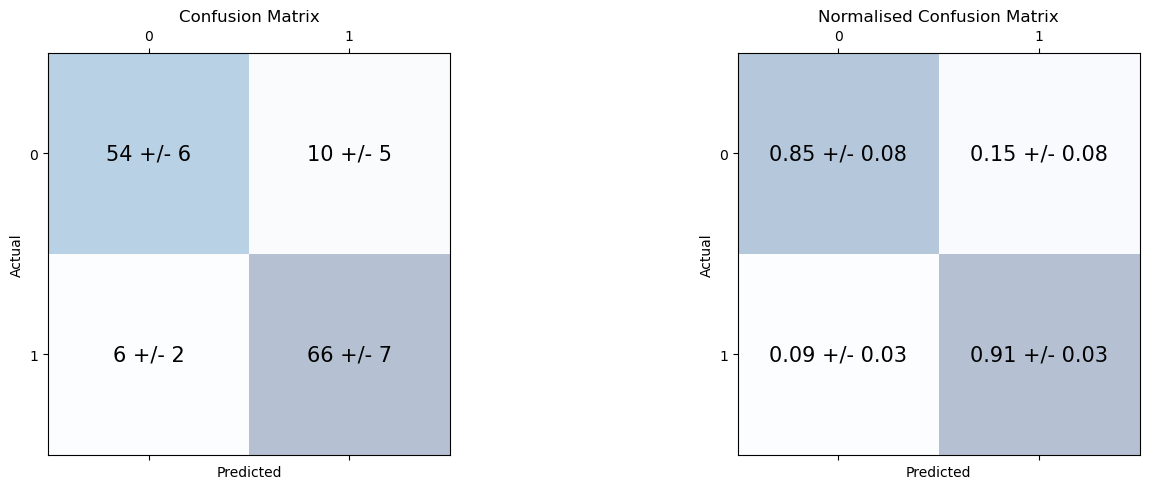

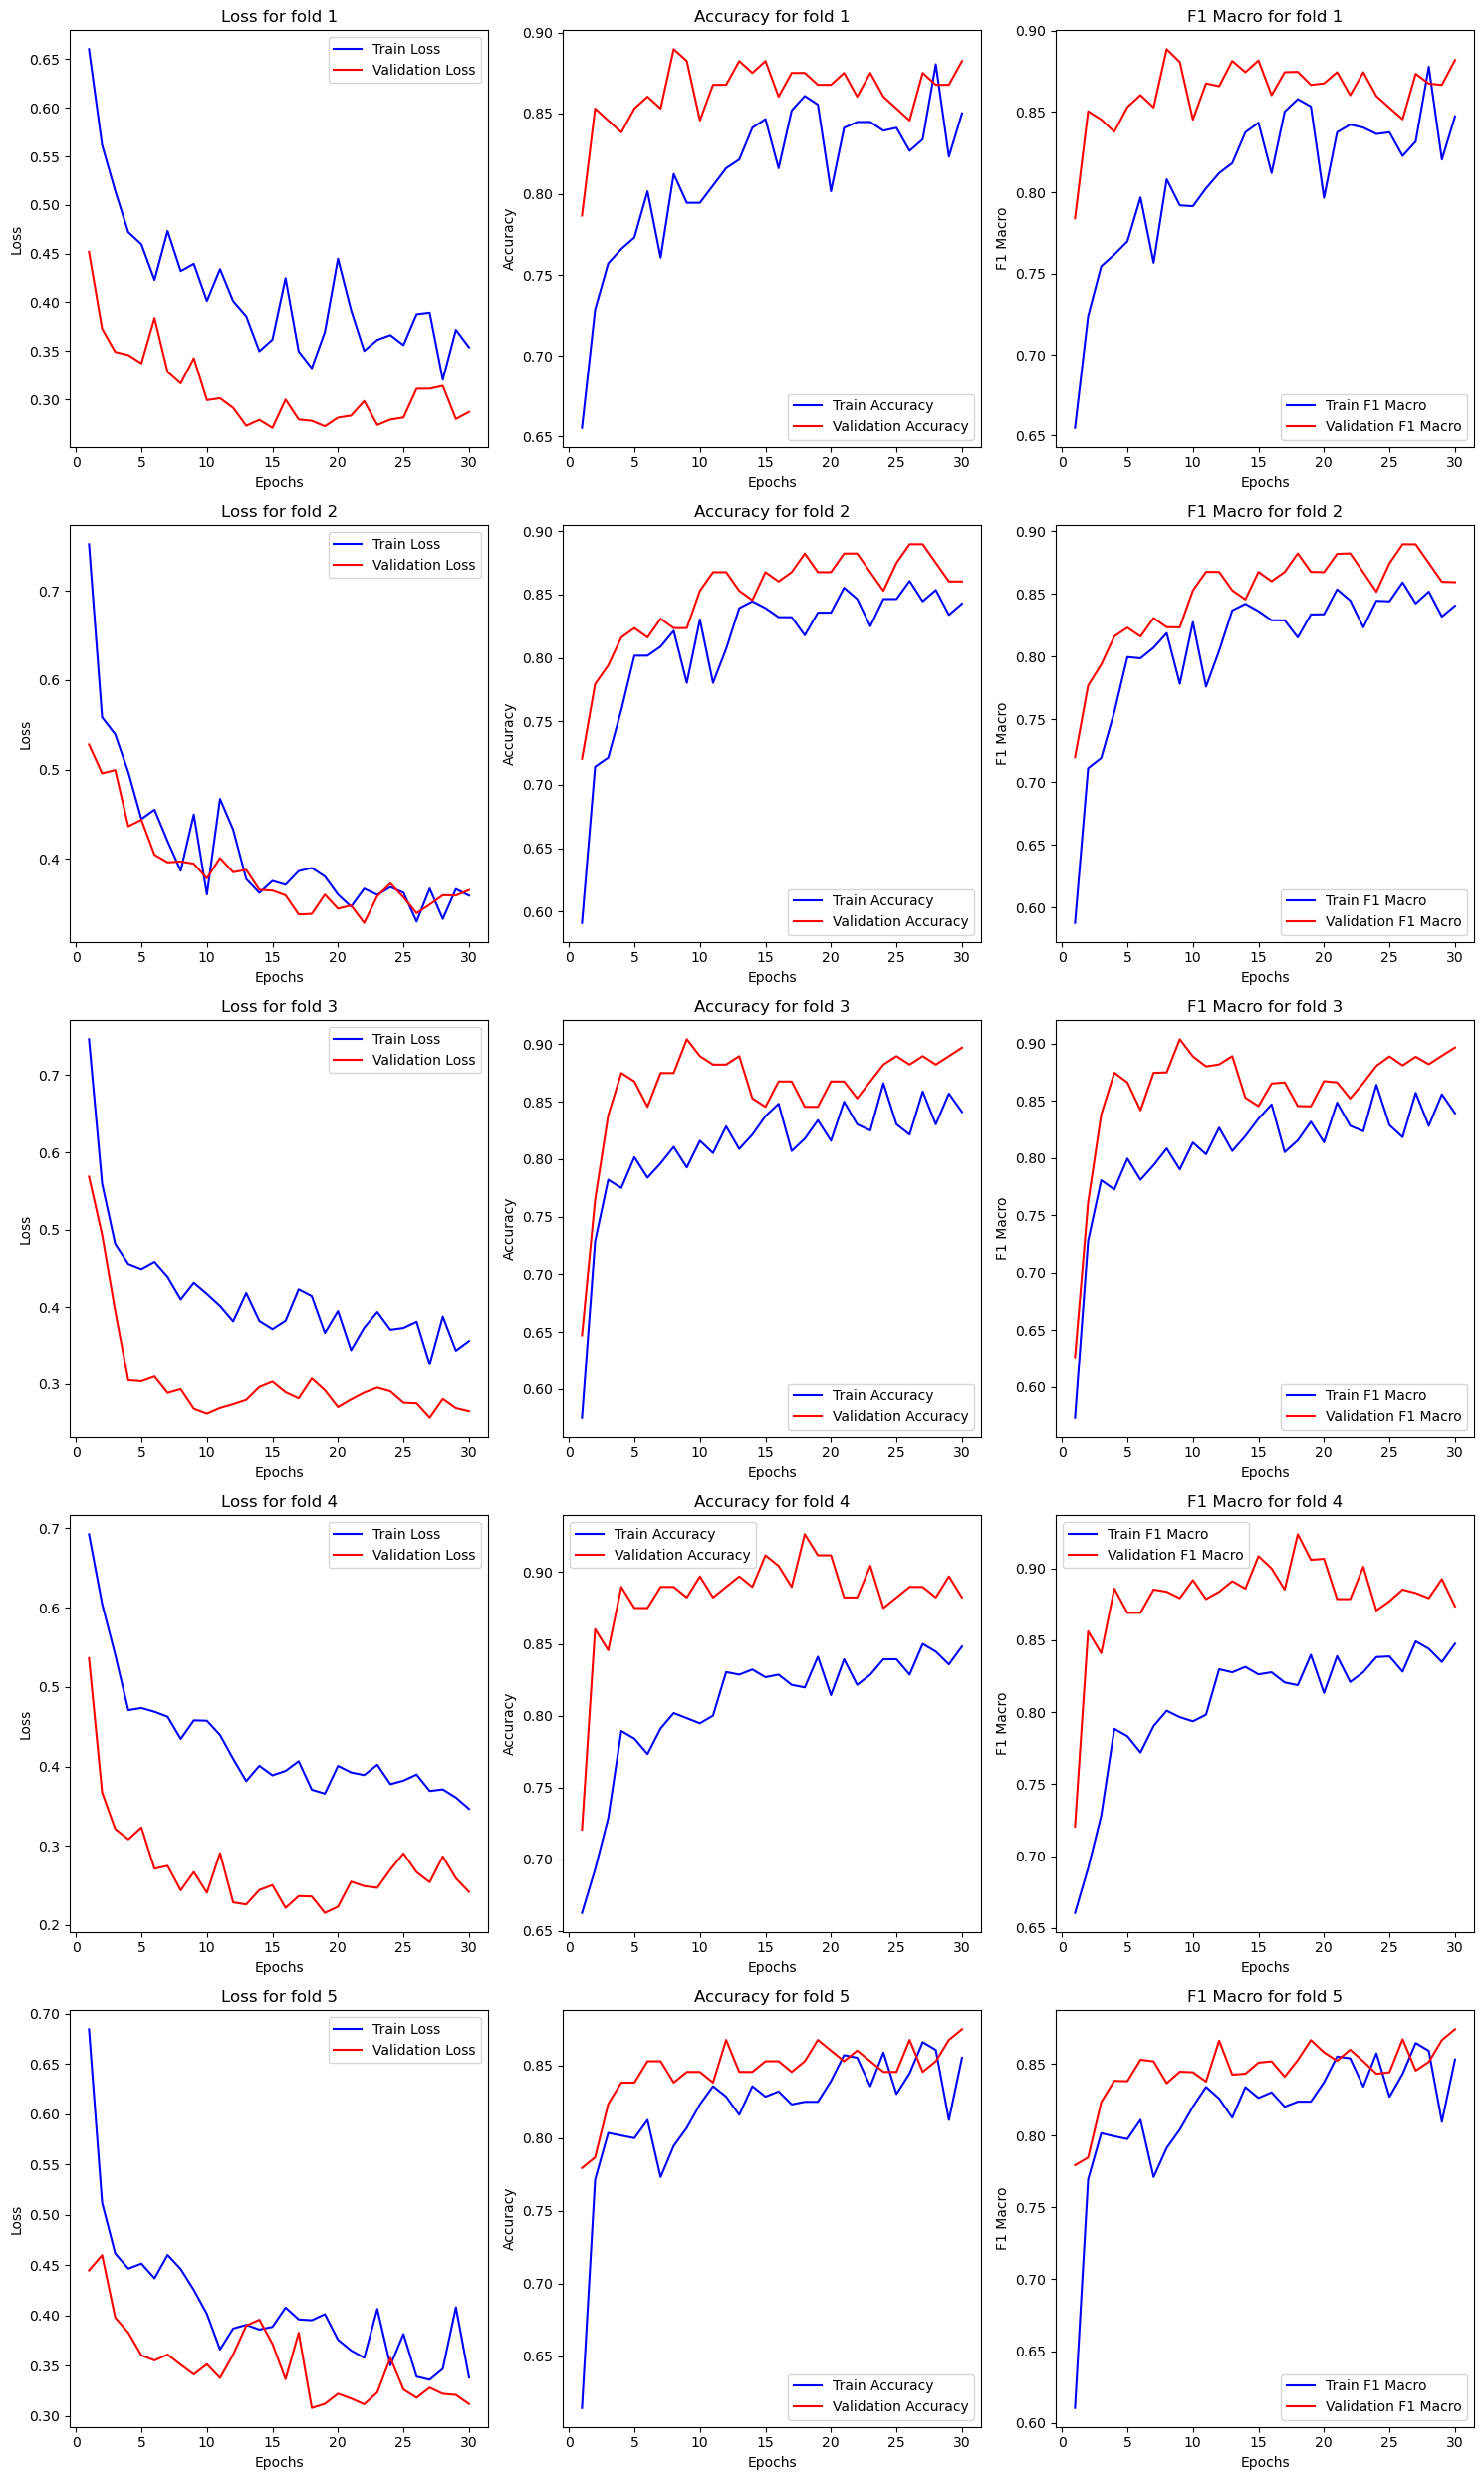

In [84]:
trg.print_val_results(results)
trg.plot_confusion_matrix(results)
trg.plot_results(results, 5)

### Test Covid data

dasdf
Test Accuracy: 0.8354
Test ROC_AUC: 0.8338
Test F1 Macro: 0.8345
Test F1 Phen1: 0.8471
Test F1 Phen2: 0.8219
Test Recall Phen1: 0.8780
Test Recall Phen2: 0.7895


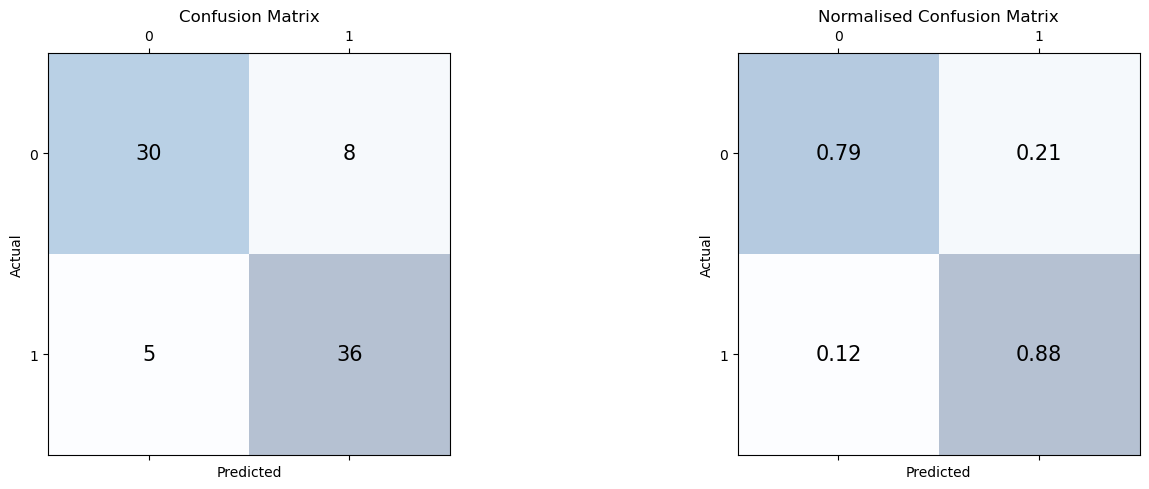

In [85]:
num_folds = 5  
model_save_dir = "trained_models/Covid_BINN" 

# Load test data
protein_matrix_test = fit_data_matrix_to_network_input(covid_test, features=network.inputs)
X_test, y_test = generate_data(protein_matrix_test, design_matrix=covid_test_design)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long) 
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=8)  

all_predictions = []

# go through each of the 5 models
for fold in range(1, num_folds + 1):
    model_path = f"{model_save_dir}/model_fold_{fold}.pth"
    model = binn_covid 
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(binn_covid.device)  

    fold_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(binn_covid.device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            fold_predictions.extend(predicted.cpu().numpy())

    all_predictions.append(fold_predictions)

all_predictions = list(map(list, zip(*all_predictions)))
majority_votes = [Counter(sample_predictions).most_common(1)[0][0] for sample_predictions in all_predictions]

# Calculate accuracy
y_test = y_test_tensor.numpy()  # Convert to numpy if it's a tensor
correct = sum(1 for true, pred in zip(y_test, majority_votes) if true == pred)
accuracy = 100 * correct / len(y_test)


test_confusion_matrix = confusion_matrix(y_test, majority_votes, labels=[0, 1])

test_roc_auc = roc_auc_score(y_test, majority_votes)

recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = trg.calculate_metrics(test_confusion_matrix)



# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC_AUC: {test_roc_auc:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")
print(f"Test F1 Phen1: {f1_phen1:.4f}")
print(f"Test F1 Phen2: {f1_phen2:.4f}")
print(f"Test Recall Phen1: {recall_phen1:.4f}")
print(f"Test Recall Phen2: {recall_phen2:.4f}")
trg.plot_confusion_matrix(test_confusion_matrix, use = 'test')